# What about data?
- Generally, when you have to deal with image, text, audio, or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.Tensor`
    + For images, packages such as Pillow, OpenCV are useful
    + For audio, packages such as scipy and librosa
    + For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
- Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformer for images, viz, `torchvision.datasets` and `torch.utils.data.DataLoader`
- This provides a huge convinience and avoid writing boilerplate code
- For this tutorial, we will use the CIFAR10 dataset. It has the classes 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', horse', 'ship', 'truck'
- The image in CIFAR-10 are of the size 3x32x32, i.e 3-channel color images of 32x32 pixels in size

# Training an image classifier
- we will do the following steps in order:
    1. Load and normalize the CIFAR10 trainging and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data

## Load and normaize CIFAR10
- Using `torchvision`, it's extremely easy to load CIFAR10

### Load CIFAR10

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

### Normaize CIFAR10
- The output of torch vision datasets are PILImage images of range [0, 1]
- We transform them to Tensors of normalized range [-1, 1]
- If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0.

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
# Train
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Show training tmages

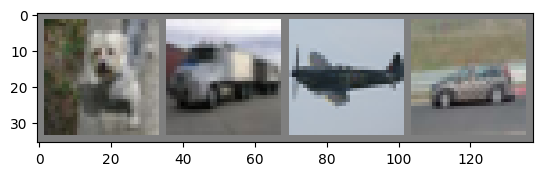

dog   truck plane car  


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show image
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define a Convolutional Neural Network
- Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined)

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer
- Let's use a Calssification Cross-Entropy loss and SGD with momentum

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## Train the network
- This is when things start to get interesting
- We simply have to loop over our data interator, and feed the inputs to the network and optimize

### Train

In [14]:
for epoch in range(2):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print stats
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.263
[1,  4000] loss: 1.906
[1,  6000] loss: 1.684
[1,  8000] loss: 1.581
[1, 10000] loss: 1.514
[1, 12000] loss: 1.450
[2,  2000] loss: 1.392
[2,  4000] loss: 1.350
[2,  6000] loss: 1.335
[2,  8000] loss: 1.334
[2, 10000] loss: 1.287
[2, 12000] loss: 1.281
Finished Training


### Save the trained model

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data
- We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all
- We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions

### Display an image from the test set

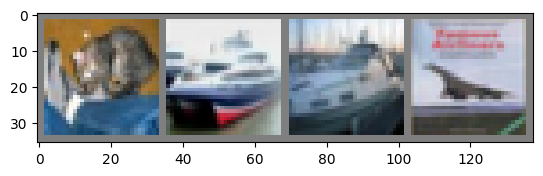

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print Images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Load back our saved model
- saving and re-loading the model wasn’t necessary

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Test the trained model with the current tesing images

In [18]:
outputs = net(images)

### Select the right class
- The outputs are energies (probabilities) for 10 classes
- The higher the energy for a class, the more the network thinks that the image is of the particular class
- Get the index of the highest energy

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  ship 


### Performance on the whole dataset

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


### Find out which class does well which doesn't

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.5 %
Accuracy for class: car   is 68.1 %
Accuracy for class: bird  is 24.4 %
Accuracy for class: cat   is 41.2 %
Accuracy for class: deer  is 57.0 %
Accuracy for class: dog   is 46.5 %
Accuracy for class: frog  is 60.1 %
Accuracy for class: horse is 69.5 %
Accuracy for class: ship  is 64.3 %
Accuracy for class: truck is 64.6 %


# Training on GPU
- Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU

## Define CUDA Device
- Let's first define our device as the first visible cuda device if we have CUDA available

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Run under CUDA
- The rest of this section assumes that device is a CUDA device.
- Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors
- Remember that you will have to send the inputs and targets at every step to the GPU too

In [24]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)